In [1]:
using Clapeyron, PyCall, LaTeXStrings, GenericLinearAlgebra, CSV, Tables
import PyPlot; plt = PyPlot

PyPlot

In [2]:
rcParams = PyDict(plt.matplotlib["rcParams"])

WIDTH = 1.5 * 8.3 / 2.54
DOUBLE_WIDTH = 1.5 * 17.1 / 2.54
DPI = 150
rcParams["axes.labelsize"]= 14
rcParams["axes.xmargin"]= 0
rcParams["axes.ymargin"]= .1
rcParams["lines.markersize"]= 5
rcParams["figure.dpi"]= DPI
rcParams["figure.autolayout"]= true
rcParams["figure.figsize"]= (WIDTH, 3 * WIDTH / 4)
rcParams["figure.facecolor"]= "white"
rcParams["font.size"]= 12
rcParams["grid.color"]= "0"
rcParams["grid.linestyle"]= "-"
rcParams["legend.edgecolor"]= "1"
rcParams["legend.fontsize"]= 10
rcParams["xtick.labelsize"]= 12
rcParams["ytick.labelsize"]= 12
rcParams["xtick.direction"]= "in"
rcParams["ytick.direction"]= "in"
rcParams["font.family"]= "sans-serif"
rcParams["font.sans-serif"]= ["Arial"]
# Create color wheel
rcParams["axes.prop_cycle"] = plt.matplotlib.cycler(color=["#4063D8","#009B72","#FFB400","#D80032","#9558B2","#01172F"])

'#4063D8'
'#009B72'
'#FFB400'
'#D80032'
'#9558B2'
'#01172F'


In [3]:
include("Helmholtz_LS.jl")

a (generic function with 1 method)

# Neutral Polyampholytes

In [4]:
function phaseqObj_neut(F,model,lB,ρsup,ρco)

    fun(x)  = a(model,lB,[x[1]])
    df(x) = Clapeyron.ForwardDiff.derivative(fun,x)
    
    μsup = df(ρsup)
    μco  = df(ρco)
    
    F[1] = (μsup.-μco)
    
    F[2] = (fun(ρsup)-fun(ρco)+μco[1]*ρco[1]-μsup[1]*ρsup[1])
    # Add mass balance
    return F
end

function critObj_neut(F,model,lBc,ρc)
    fun(x)  = a(model,lBc,[x[1]])
    df(x) = Clapeyron.ForwardDiff.derivative(fun,x)
    d2f(x) = Clapeyron.ForwardDiff.derivative(df,x)
    d3f(x) = Clapeyron.ForwardDiff.derivative(d2f,x)
        
    F[1] = d2f(ρc)
    
    F[2] = d3f(ρc)
    return F
end

critObj_neut (generic function with 1 method)

In [5]:
N = 100
Nu = 1:10:(N-1)
ρ = zeros(N,length(Nu),2)
lB = zeros(N,length(Nu))
x0c = [0.2,-2.4]

for i in 1:length(Nu)
    model = LS(["PAL"]; userlocations=(;
                    N = [N],
                    Nu = [Nu[i]],
                    Z = [0]))

    objcrit!(F,x) = critObj_neut(F,model,x[1],exp10(x[2]))
    x = Clapeyron.Solvers.nlsolve(objcrit!,x0c)
    x0c = Clapeyron.Solvers.x_sol(x)
    lBc = x0c[1]
    lB[:,i] .= LinRange(4.5,lBc,N)

    x0 = [-100,-0.2]
    for j in 1:N
        obj!(F,x) = phaseqObj_neut(F,model,lB[j],exp10(x[1]),exp10(x[2]))
        x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
        x0 = Clapeyron.Solvers.x_sol(x)
        ρ[j,i,:] = exp10.(x0)
        if abs(ρ[j,i,1] - ρ[j,i,2]) < 1e-3
            break
        end
    end
end


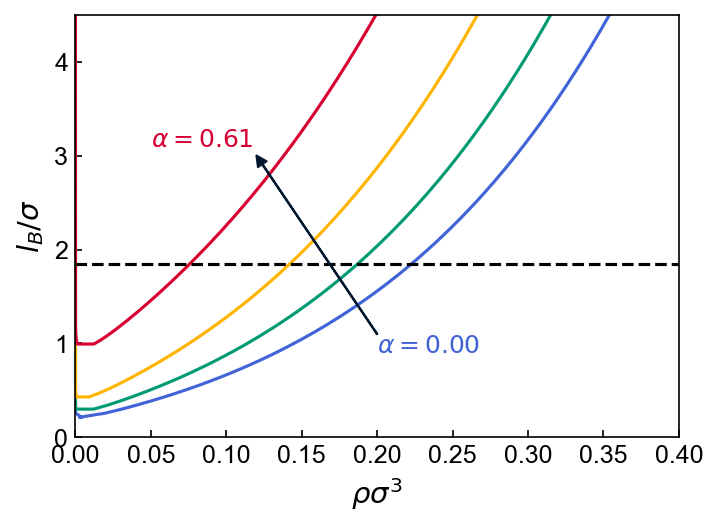

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [8]:
plt.clf()
for j in vcat(1:2:length(Nu),length(Nu))
    χ = (Nu[j] - 1)/(N - 2)
    if isnothing(findfirst(x->x==0,ρ[:,j,1]))
        idxend = N
    else
        idxend = findfirst(x->x==0,ρ[:,j,1])-2
    end
    plt.plot(vcat(ρ[1:idxend,j,1],reverse(ρ[1:idxend,j,2])),(vcat(lB[1:idxend],reverse(lB[1:idxend]))),label="χ = $χ")
end
plt.annotate("", xy=(0.12, 3.), xytext=(0.2, 1.1), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))
plt.plot([0,0.4],[1.85,1.85],"k--")
plt.text(0.2,0.9,L"\alpha=0.00",color="#4063D8")
plt.text(0.05,3.1,L"\alpha=0.61",color="C3")
plt.ylabel(L"l_B/\sigma")
plt.xlabel(L"\rho\sigma^3")
plt.xlim(0,0.4)
plt.ylim(0,4.5)
plt.savefig("figures/phaseq_neut_chi.pdf",dpi=300)
plt.savefig("figures/phaseq_neut_chi.png",dpi=300)
display(plt.gcf())

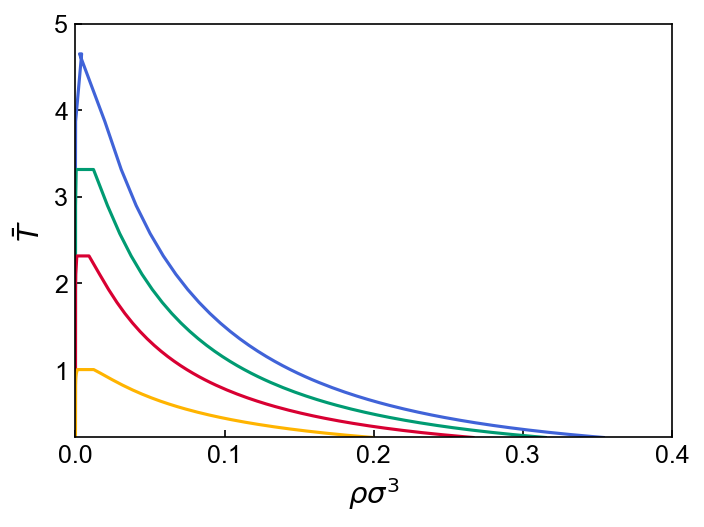

In [49]:
plt.clf()
for j in vcat(1:2:length(Nu),length(Nu))
    χ = (Nu[j] - 1)/(N - 2)
    if isnothing(findfirst(x->x==0,ρ[:,j,1]))
        idxend = N
    else
        idxend = findfirst(x->x==0,ρ[:,j,1])-2
    end
    plt.plot(vcat(ρ[1:idxend,j,1],reverse(ρ[1:idxend,j,2])),1 ./(vcat(lB[1:idxend],reverse(lB[1:idxend]))),label="χ = $χ")
end
# plt.annotate("", xy=(0.12, 3.), xytext=(0.2, 1.1), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))
# plt.text(0.2,0.9,L"\chi=0.00",color="#4063D8")
# plt.text(0.05,3.1,L"\chi=0.61",color="C3")
plt.ylabel(L"\bar{T}")
plt.xlabel(L"\rho\sigma^3")
plt.xlim(0,0.4)
plt.ylim(1/4.5,5.0)
# plt.savefig("phaseq_neut.pdf",dpi=300)
display(plt.gcf())

In [9]:
lB = LinRange(1.5,4.5,10)
N = 100
Nu = 1:(N-1)
ρ = zeros(N,Nu[end],2)


for j in 1:length(lB)
    x0 = [-0.6,-70]
    for i in Nu
        model = LS(["PAL"]; userlocations=(;
                    N = [N],
                    Nu = [i],
                    Z = [0]))
        obj!(F,x) = phaseqObj_neut(F,model,lB[j],exp10(x[1]),exp10(x[2]))
        x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
        x0 = Clapeyron.Solvers.x_sol(x)
        ρ[j,i,:] = exp10.(x0)
        if abs(ρ[j,i,1] - ρ[j,i,2]) < 1e-3
            break
        end
    end
end


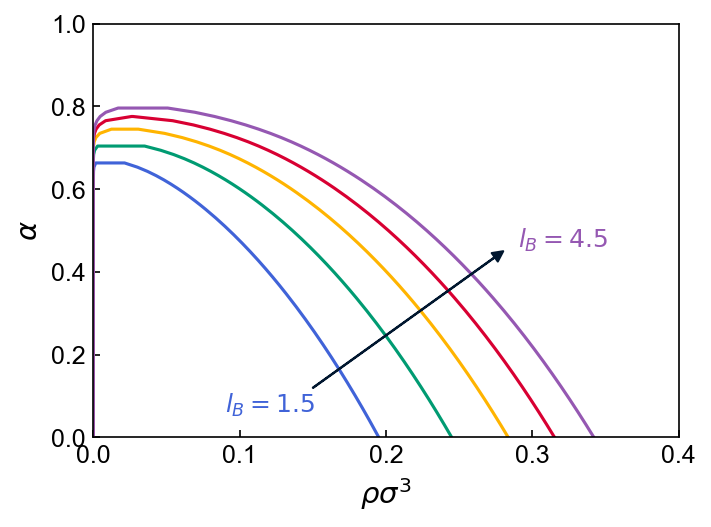

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [10]:
plt.clf()
for i in 1:2:length(lB)
    idxend = findfirst(x->x==0,ρ[i,:,1])-2
    plt.plot(vcat(ρ[i,1:idxend,1],reverse(ρ[i,1:idxend,2])),(vcat(1:idxend,reverse(1:idxend)).-1)/(N-2),label="lB = $(lB[i])")
end
plt.annotate("", xy=(0.28, 0.45), xytext=(0.15, 0.12), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))
plt.text(0.09,0.06,L"l_B=1.5",color="#4063D8")
plt.text(0.29,0.46,L"l_B=4.5",color="#9558B2")
plt.ylabel(L"\alpha")
plt.xlabel(L"\rho\sigma^3")
plt.xlim(0,0.4)
plt.ylim(0,1)
plt.savefig("phaseq_neut_alpha.pdf",dpi=300)
plt.savefig("phaseq_neut_alpha.png",dpi=300)
display(plt.gcf())

In [22]:
N = 100
Nu = 1:(N-1)
x0 = [0.2,-2.4]

X = zeros(length(Nu),2)

for i in 1:length(Nu)
    model = LS(["PAL"]; userlocations=(;
                N = [N],
                Nu = [Nu[i]],
                Z = [0]))
    obj!(F,x) = critObj_neut(F,model,x[1],exp10(x[2]))
    x = Clapeyron.Solvers.nlsolve(obj!,x0)
    x0 = Clapeyron.Solvers.x_sol(x)
    X[i,1] = x0[1]
    X[i,2] = exp10(x0[2])
end

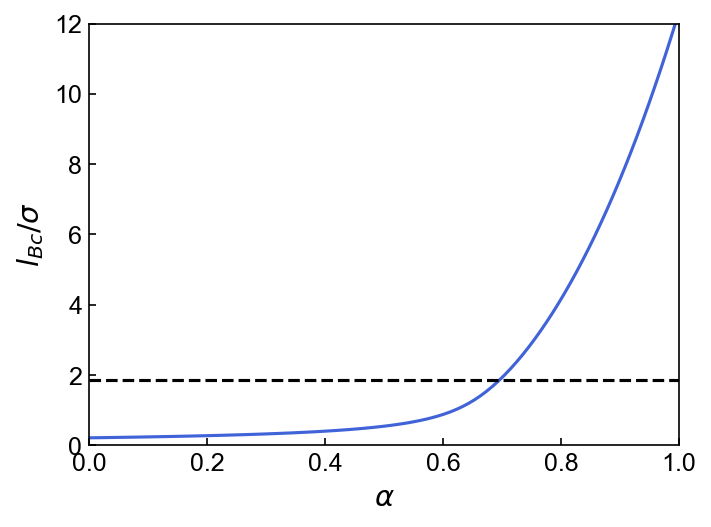

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [23]:
plt.clf()
plt.plot((Nu.-1)./(N-2),X[:,1])
plt.plot([0,1],[1.85,1.85],"--",color="black")
plt.ylabel(L"l_{Bc} / \sigma")
plt.xlabel(L"\alpha")
# plt.xlim(0,0.4)
plt.xlim(0,1)
plt.ylim(0,12)
plt.savefig("crit_neut.pdf",dpi=300)
plt.savefig("crit_neut.png",dpi=300)
display(plt.gcf())

# Charged Polyampholytes

In [13]:
function phaseqObj_chrg(F,model,lB,ρsup,ρco)
    Z = model.params.Z.values
    N = model.params.N.values
    ν = abs(Z[1]/Z[2])

    fun(x)  = a(model,lB,[x[1],x[1]/N[1]*ν])
    df(x) = Clapeyron.ForwardDiff.derivative(fun,x)
    
    μsup = df(ρsup)
    μco  = df(ρco)
    
    F[1] = (μsup.-μco)
    
    F[2] = (fun(ρsup)-fun(ρco)+μco[1]*ρco[1]-μsup[1]*ρsup[1])
    # Add mass balance
    return F
end

function critObj_chrg(F,model,lBc,ρc)
    Z = model.params.Z.values
    ν = abs(Z[1]/Z[2])

    fun(x)  = a(model,lBc,[x[1],x[1]/N[1]*ν])
    df(x) = Clapeyron.ForwardDiff.derivative(fun,x)
    d2f(x) = Clapeyron.ForwardDiff.derivative(df,x)
    d3f(x) = Clapeyron.ForwardDiff.derivative(d2f,x)
        
    F[1] = d2f(ρc)
    
    F[2] = d3f(ρc)
    return F
end

critObj_chrg (generic function with 1 method)

In [16]:
N = 100
Nu = 1:8:40
lB = 1.5

nZ = 0:-1:-30

ρ = zeros(length(Nu),length(nZ),2)

for j in 1:length(Nu)
    x0 = [-0.75,-16]

    model = LS(["PAL"]; userlocations=(;
                    N = [N],
                    Nu = [Nu[j]],
                    Z = [0]))
    obj_crit!(F,x) = phaseqObj_neut(F,model,lB,exp10(x[1]),exp10(x[2]))
    x = Clapeyron.Solvers.nlsolve(obj_crit!,big.(x0))
    # x0 = Clapeyron.Solvers.x_sol(x)
    ρ[j,1,:] = exp10.(Clapeyron.Solvers.x_sol(x))

    for i in 2:length(nZ)
        model = LS(["PAL","I"]; userlocations=(;
                    N = [N,1],
                    Nu = [Nu[j],0],
                    Z = [nZ[i],1]))
        obj!(F,x) = phaseqObj_chrg(F,model,lB,exp10(x[1]),exp10(x[2]))
        x = Clapeyron.Solvers.nlsolve(obj!,big.(x0))
        x0 = Clapeyron.Solvers.x_sol(x)
        ρ[j,i,:] = exp10.(x0)
        if abs(ρ[j,i,1] - ρ[j,i,2]) < 1e-3
            break
        end
    end
end

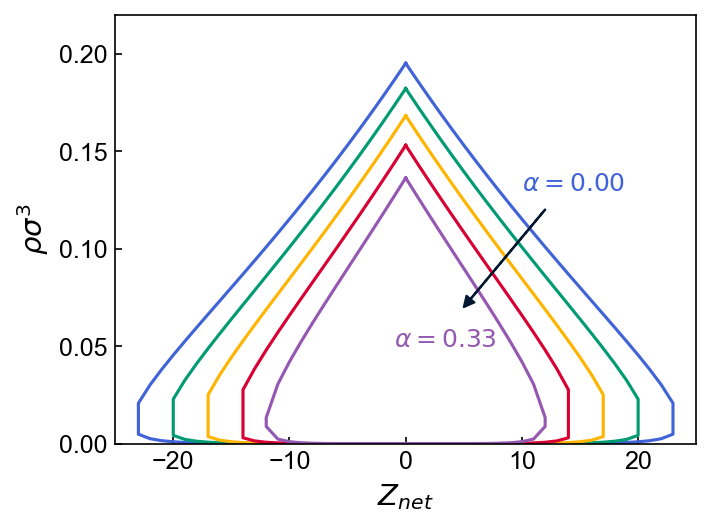

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [17]:
plt.clf()
for j in 1:length(Nu)
    idxend = findfirst(x->x==0,ρ[j,:,1])-2
    X = vcat(nZ[1:idxend],reverse(nZ[1:idxend]),nZ[1:idxend].*-1,reverse(nZ[1:idxend].*-1))
    Y = vcat(ρ[j,1:idxend,1],reverse(ρ[j,1:idxend,2]),ρ[j,1:idxend,2],reverse(ρ[j,1:idxend,1]))
    plt.plot(X,Y)
end
plt.annotate("", xy=(5, 0.07), xytext=(12, 0.12), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))
plt.text(10,0.13,L"\alpha=0.00",color="#4063D8")
plt.text(-1,0.05,L"\alpha=0.33",color="#9558B2")
plt.ylabel(L"\rho\sigma^3")
plt.xlabel(L"Z_{net}")
plt.xlim(-25,25)
plt.ylim(0,0.22)
plt.savefig("phaseq_chrg.pdf",dpi=300)
display(plt.gcf())

In [18]:
N = 100
Nu = 1:99
nZ = 0:-2:-98

X = zeros(length(Nu),length(nZ),2)
x0 = [0.2,-2.4]
for j in 1:length(Nu)
    model = LS(["PAL"]; userlocations=(;
                N = [N],
                Nu = [Nu[j]],
                Z = [0]))
    obj!(F,x) = critObj_neut(F,model,x[1],exp10(x[2]))
    x = Clapeyron.Solvers.nlsolve(obj!,x0)
    x0 = Clapeyron.Solvers.x_sol(x)
    X[j,1,1] = x0[1]
    X[j,1,2] = exp10(x0[2])
end

X0 = zeros(length(nZ),2)
X0[1,:] = [0.2,-2.4]

for i in 2:length(nZ)
    model = LS(["PAL","I"]; userlocations=(;
                    N = [N,1],
                    Nu = [Nu[1],0],
                    Z = [nZ[i],1]))
    obj!(F,x) = critObj_chrg(F,model,x[1],exp10(x[2]))
    x = Clapeyron.Solvers.nlsolve(obj!,X0[i-1,:])
    x0 = Clapeyron.Solvers.x_sol(x)
    X0[i,:] = x0
    X[1,i,1] = x0[1]
    X[1,i,2] = exp10(x0[2])
end

for i in 2:length(nZ)
    x0 = X0[i,:]
    for j in 1:length(Nu)
        if abs(nZ[i])>(N-Nu[j]-1)
            break
        end
        model = LS(["PAL","I"]; userlocations=(;
                        N = [N,1],
                        Nu = [Nu[j],0],
                        Z = [nZ[i],1]))
        obj!(F,x) = critObj_chrg(F,model,x[1],exp10(x[2]))
        x = Clapeyron.Solvers.nlsolve(obj!,x0)
        x0 = Clapeyron.Solvers.x_sol(x)
        X[j,i,1] = x0[1]
        X[j,i,2] = exp10(x0[2])
    end
end

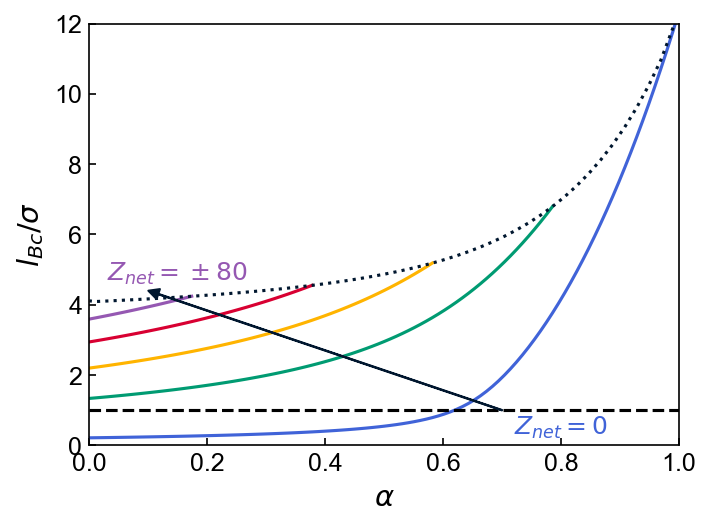

sys:1: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [20]:
plt.clf()
Xmax = zeros(50)
Ymax = zeros(50)
for i in 1:50
    if any(X[:,i,1].==0)
        idxend = findfirst(x->x==0,X[:,i,1])-2
        if idxend <= 0
            idxend = 1
        end
    else
        idxend = length(Nu)
    end
    Xmax[i] = (Nu[idxend]-1)/(N-2)
    Ymax[i] = X[idxend,i,1]
    if mod(i-1,10)==0
        plt.plot((Nu[1:idxend].-1)/(N-2),X[1:idxend,i,1],label="Z = $(nZ[i])")
        # println(nZ[i])
    end
end
plt.plot(Xmax,Ymax,":")
plt.plot([0,1],[1.,1.],"--",color="black")
plt.annotate("", xy=(0.1,4.4), xytext=(0.7,1.), arrowprops=Dict(:headwidth=>5, :headlength=>5, :width=>0.2, :color=>"#01172F"))
plt.text(0.72,0.3,L"Z_{net}=0",color="#4063D8")
plt.text(0.03,4.7,L"Z_{net}=\pm 80",color="#9558B2")
plt.ylabel(L"l_{Bc} / \sigma")
plt.xlabel(L"\alpha")
plt.xlim(0,1)
plt.ylim(0,12)
plt.savefig("figures/crit_chrg.png",dpi=300)
plt.savefig("figures/crit_chrg.pdf",dpi=300)
display(plt.gcf())